In [1]:
# code to sort reactome pathways nicely into clusters

In [2]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
data_path = "./without_sulfo/compassionate_buck-v2/Leiden-0.5/nodes.csv"
FLD = os.path.split(data_path)[0]

In [4]:
pathways = pd.read_csv('https://download.reactome.org/95/ReactomePathways.txt', sep='\t', header=None)
pathways.columns = ['ID','name','species']
human_pathways = pathways[pathways.species=='Homo sapiens'].copy(deep=True)
id2name = human_pathways.set_index('ID').to_dict()['name']

In [5]:
hierarchy = pd.read_csv('https://download.reactome.org/95/ReactomePathwaysRelation.txt', sep='\t', header=None)
hierarchy.columns = ['parent','child']
hierarchy_hs = hierarchy[hierarchy.child.isin(id2name)].copy(deep=True)
hierarchy_hs

,parent,child
11142,R-HSA-109581,R-HSA-109606
11143,R-HSA-109581,R-HSA-169911
11144,R-HSA-109581,R-HSA-5357769
11145,R-HSA-109581,R-HSA-75153
11146,R-HSA-109582,R-HSA-140877
...,...,...
14001,R-HSA-9958790,R-HSA-427652
14002,R-HSA-9958790,R-HSA-433137
14003,R-HSA-9958863,R-HSA-352230
14004,R-HSA-9958863,R-HSA-428559


In [6]:
# hierarchy_hs.to_csv('ReactomePathwaysHierarchyHuman.csv', index=False, encoding='utf-8')

In [7]:
hierarchy_hs['parent_name'] = hierarchy_hs['parent'].map(id2name)
hierarchy_hs['child_name']  = hierarchy_hs['child'].map(id2name)
hierarchy_hs.sort_values('parent_name')

,parent,child,parent_name,child_name
12662,R-HSA-5619084,R-HSA-5684045,ABC transporter disorders,Defective ABCD1 causes ALD
12653,R-HSA-5619084,R-HSA-5679001,ABC transporter disorders,Defective ABCC2 causes DJS
12652,R-HSA-5619084,R-HSA-5678895,ABC transporter disorders,Defective CFTR causes cystic fibrosis
12651,R-HSA-5619084,R-HSA-5678771,ABC transporter disorders,"Defective ABCB4 causes PFIC3, ICP3 and GBD1"
12650,R-HSA-5619084,R-HSA-5678520,ABC transporter disorders,Defective ABCB11 causes PFIC2 and BRIC2
...,...,...,...,...
13096,R-HSA-72306,R-HSA-6784531,tRNA processing,tRNA processing in the nucleus
13097,R-HSA-72306,R-HSA-6785470,tRNA processing,tRNA processing in the mitochondrion
13098,R-HSA-72306,R-HSA-6787450,tRNA processing,tRNA modification in the mitochondrion
11894,R-HSA-199992,R-HSA-432720,trans-Golgi Network Vesicle Budding,Lysosome Vesicle Biogenesis


2864


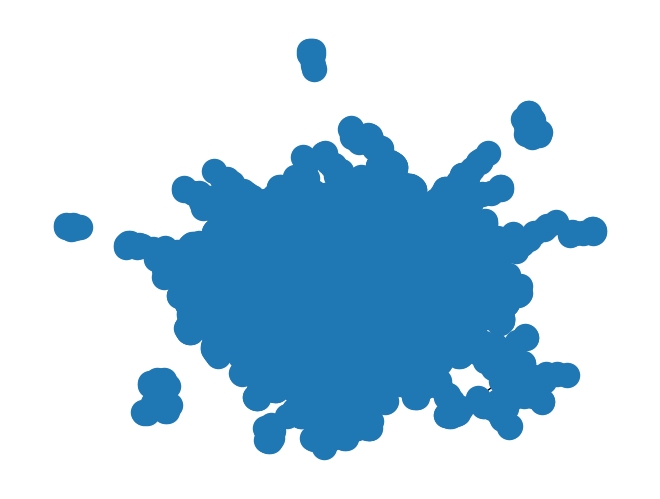

In [8]:
import networkx as nx
G = nx.Graph()
G.add_edges_from(
    [_ for _ in zip(hierarchy_hs.parent, hierarchy_hs.child)]
)
print(len(G.edges()))
nx.draw(G)

In [9]:
def pathway_distance(G,a,b):
    try:
        return len(nx.shortest_path(G, a, b))
    except nx.NetworkXNoPath as E:
        return 100

hierarchy_hs['distance'] = hierarchy_hs.apply(lambda row: pathway_distance(G, row.parent, row.child), axis=1)
hierarchy_hs.sort_values('distance')

,parent,child,parent_name,child_name,distance
14005,R-HSA-9959399,R-HSA-427975,SLC-mediated transport of oligopeptides,Proton/oligopeptide cotransporters,2
14004,R-HSA-9958863,R-HSA-428559,SLC-mediated transport of amino acids,Proton-coupled neutral amino acid transporters,2
14003,R-HSA-9958863,R-HSA-352230,SLC-mediated transport of amino acids,Amino acid transport across the plasma membrane,2
14002,R-HSA-9958790,R-HSA-433137,SLC-mediated transport of inorganic anions,"Sodium-coupled sulphate, di- and tri-carboxyla...",2
14001,R-HSA-9958790,R-HSA-427652,SLC-mediated transport of inorganic anions,Sodium-coupled phosphate cotransporters,2
...,...,...,...,...,...
11162,R-HSA-110313,R-HSA-110312,Translesion synthesis by Y family DNA polymera...,Translesion synthesis by REV1,2
11161,R-HSA-109704,R-HSA-165158,PI3K Cascade,Activation of AKT2,2
11160,R-HSA-109704,R-HSA-109703,PI3K Cascade,PKB-mediated events,2
11159,R-HSA-109703,R-HSA-165160,PKB-mediated events,PDE3B signalling,2


In [10]:
all_pathways = list(set(pd.read_csv(os.path.join(FLD,'results_combo.csv')).stId))
all_distances = []
for a in all_pathways:
    for b in all_pathways:
        all_distances.append([a, b, pathway_distance(G,a,b)])
all_distances = pd.DataFrame(all_distances, columns=['pathwayA', 'pathwayB','distance'])
all_distances['pathwayA_name'] = '[' + all_distances.pathwayA + '] ' + all_distances.pathwayA.map(id2name)
all_distances['pathwayB_name'] = '[' + all_distances.pathwayB + '] ' + all_distances.pathwayB.map(id2name)
all_distances.tail()

,pathwayA,pathwayB,distance,pathwayA_name,pathwayB_name
5471,R-HSA-1643685,R-HSA-3214841,100,[R-HSA-1643685] Disease,[R-HSA-3214841] PKMTs methylate histone lysines
5472,R-HSA-1643685,R-HSA-9665737,4,[R-HSA-1643685] Disease,[R-HSA-9665737] Drug resistance in ERBB2 TMD/J...
5473,R-HSA-1643685,R-HSA-4839726,100,[R-HSA-1643685] Disease,[R-HSA-4839726] Chromatin organization
5474,R-HSA-1643685,R-HSA-75153,100,[R-HSA-1643685] Disease,[R-HSA-75153] Apoptotic execution phase
5475,R-HSA-1643685,R-HSA-1643685,1,[R-HSA-1643685] Disease,[R-HSA-1643685] Disease


In [11]:
len(all_pathways) * (len(all_pathways)-1)

5402

In [12]:
all_distances = all_distances.pivot(index='pathwayA_name', columns='pathwayB_name', values='distance')
all_distances.head()

pathwayB_name,[R-HSA-111465] Apoptotic cleavage of cellular proteins,[R-HSA-140342] Apoptosis induced DNA fragmentation,[R-HSA-1500931] Cell-Cell communication,[R-HSA-156842] Eukaryotic Translation Elongation,[R-HSA-156902] Peptide chain elongation,[R-HSA-1640170] Cell Cycle,[R-HSA-1643685] Disease,[R-HSA-168255] Influenza Infection,[R-HSA-168273] Influenza Viral RNA Transcription and Replication,[R-HSA-176033] Interactions of Vpr with host cellular proteins,...,[R-HSA-9711097] Cellular response to starvation,"[R-HSA-9716542] Signaling by Rho GTPases, Miro GTPases and RHOBTB3",[R-HSA-9759476] Regulation of Homotypic Cell-Cell Adhesion,[R-HSA-9764265] Regulation of CDH1 Expression and Function,[R-HSA-9764274] Regulation of Expression and Function of Type I Classical Cadherins,[R-HSA-9770562] mRNA Polyadenylation,[R-HSA-9772755] Formation of WDR5-containing histone-modifying complexes,[R-HSA-9824446] Viral Infection Pathways,[R-HSA-9839923] Dengue Virus Infection,[R-HSA-9918481] Dengue Virus-Host Interactions
pathwayA_name,,,,,,,,,,,,,,,,,,,,,
[R-HSA-111465] Apoptotic cleavage of cellular proteins,1,3,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
[R-HSA-140342] Apoptosis induced DNA fragmentation,3,1,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
[R-HSA-1500931] Cell-Cell communication,100,100,1,100,100,100,100,100,100,100,...,100,100,5,7,6,100,100,100,100,100
[R-HSA-156842] Eukaryotic Translation Elongation,100,100,100,1,2,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
[R-HSA-156902] Peptide chain elongation,100,100,100,2,1,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100


In [13]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

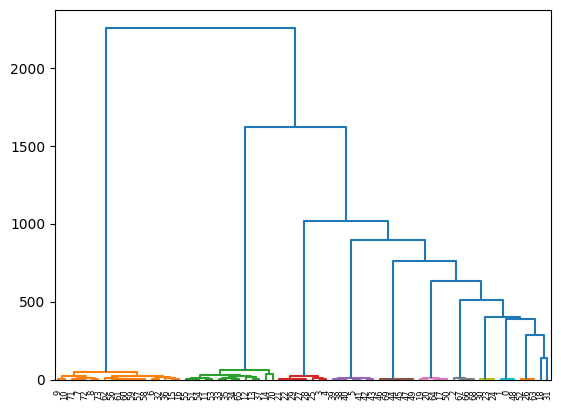

In [14]:
Z = linkage(all_distances, method='ward')
den = dendrogram(
    Z, 
    # truncate_mode='lastp'
    color_threshold=100
)
plt.show()

In [15]:
clusters = pd.DataFrame(([list(all_distances.index)[i] for i in den['leaves']], den['leaves_color_list'])).T
clusters.columns = ['name','cluster']
clusters

,name,cluster
0,[R-HSA-176033] Interactions of Vpr with host c...,C1
1,[R-HSA-180910] Vpr-mediated nuclear import of ...,C1
2,[R-HSA-9824446] Viral Infection Pathways,C1
3,[R-HSA-168255] Influenza Infection,C1
4,[R-HSA-9839923] Dengue Virus Infection,C1
...,...,...
69,[R-HSA-9010553] Regulation of expression of SL...,C1
70,[R-HSA-422475] Axon guidance,C1
71,[R-HSA-9675108] Nervous system development,C1
72,[R-HSA-2408557] Selenocysteine synthesis,C0


In [16]:
# clusters.to_csv('ReactomePathsClusters.csv', index=False)